In [ ]:
import sys
!{sys.executable} -m pip install gem5art-artifact gem5art-run gem5art-tasks --user
!{sys.executable} -m pip install matplotlib --user

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from itertools import product as cross_product
from collections import defaultdict
import os
import pandas as pd

from zipfile import ZipFile
from gem5art.artifact import getDBConnection
import gem5art.run

In [2]:
db = getDBConnection("mongodb://glacier.cs.ucdavis.edu")
aliases = ['lavandula-viridis']
results = []
for alias in aliases:
    for run in gem5art.run.getRunsByNameLike(db, alias):
        results.append(run)
print(vars(results[0]).keys())

dict_keys(['artifacts', '_id', 'name', 'gem5_binary', 'run_script', 'gem5_artifact', 'gem5_git_artifact', 'run_script_git_artifact', 'params', 'timeout', 'outdir', 'gem5_name', 'script_name', 'running', 'enqueue_time', 'start_time', 'end_time', 'return_code', 'kill_reason', 'status', 'pid', 'task_id', 'results', 'linux_binary', 'disk_image', 'linux_binary_artifact', 'disk_image_artifact', 'linux_name', 'disk_name', 'string', 'command', 'hash', 'type', 'current_time'])


In [3]:
def init_nd_dict(depth, params_list, params, default_value):
    if depth == len(params_list) - 1:
        return {k: default_value for k in params[params_list[depth]]}
    d = {k: init_nd_dict(depth+1, params_list, params, default_value) for k in params[params_list[depth]]}
    return d
def get_benchmark_result(benchmark_name, results):
    r = []
    for run in results:
        name, params = "", {}
        part = run.string.split()
        kernel = part[2].split('-')[-1]
        params['kernel'] = kernel
        if part[3] == "boot-exit.img":
            name = 'boot-exit'
            params['cpu'] = part[4]
            params['mem_sys'] = part[5]
            params['num_cpu'] = part[6]
            params['boot_type'] = part[7]
        elif part[3].startswith("parsec"):
            if part[3] == 'parsec.img':
                name = 'parsec'
            elif part[3] == 'parsec-20.04':
                name = 'parsec-20.04'
            params['cpu'] = part[4]
            params['workload'] = part[5]
            params['size'] = part[6]
            params['num_cpu'] = part[7]
            params['mem_sys'] = 'MESI_Two_Level'
        elif part[3] == "spec-2006":
            name = 'spec-2006'
            params['cpu'] = part[4]
            params['mem_sys'] = part[5]
            params['workload'] = part[6]
            params['size'] = part[7]
        elif part[3] == "spec-2017":
            name = 'spec-2017'
            params['cpu'] = part[4]
            params['workload'] = part[5]
            params['size'] = part[6]
        params['name'] = name
        if name == benchmark_name:
            r.append((params, run))
    return r

def get_data_from_stats_file(stats_path, stats_names): # stats_names is expected to be a set
    r = {}
    with open(stats_path, "r") as f:
        for line in f.readlines():
            part = line.strip().split()
            if len(part) >= 2:
                if part[0] in stats_name:
                    r[part[0]] = part[1]
    return r

def get_stats_from_gem5run(gem5run, stats_name):
    r = {}
    
    with ZipFile(db.fs.open_download_stream(gem5run.results._id)) as myzip:
        stats_path = ""
        for name in myzip.namelist():
            if name.endswith("stats.txt"):
                stats_path = name
                break
        if stats_path == "":
            return r
        with myzip.open(stats_path, 'r') as f:
            for line in f.readlines():
                part = line.decode("utf-8").strip().split()
                if len(part) >= 2:
                    if part[0] in stats_name:
                        if part[0] in r: # only get the first stats dump
                            continue
                        r[part[0]] = part[1]
    return r

# row 0 will be at the bottom and so on
# quasicolor plot
def qcolor(ax, data, colormap, hatchmap):
    n_rows = len(data)
    n_cols = len(data[0])
    for row in range(n_rows):
        for col in range(n_cols):
            if hatchmap[data[row][col]] == '':
                ax.bar(col, height=1, width=1, bottom = row, edgecolor='white', color = colormap[data[row][col]])
            else:
                ax.bar(col, height=1, width=1, bottom = row, edgecolor='black', linewidth = 0, color = colormap[data[row][col]], hatch = hatchmap[data[row][col]])                
def plot_legends(ax, labels, colormap, hatchmap):
    for label, color, hatch in zip(labels, colormap, hatchmap):
        if hatch == '':
            ax.bar(0, 0, label=label, color=color)
        else:
            ax.bar(0, 0, label=label, color=color, hatch = hatch)

class Status:
    success = 0
    gem5_failure = 1
    kernel_panic = 2
    unsupported = 3
    unknown = 4
    separator = 5
    running = 6
    n_cats = 7
    def classify(status, kill_reason, running = "False"):
        if running == "True":
            return Status.running
        if status == "Finished":
            return Status.success
        elif status == "Failed":
            if kill_reason == "kernel panic":
                return Status.kernel_panic
            else:
                return Status.gem5_failure
        return Status.unknown
    def get_color_map():
        color_map = [None] * Status.n_cats
        color_map[Status.success] = 'green'
        color_map[Status.kernel_panic] = 'red'
        color_map[Status.gem5_failure] = 'orange'
        color_map[Status.unsupported] = 'gray'
        color_map[Status.unknown] = 'white'
        color_map[Status.running] = 'white'
        color_map[Status.separator] = 'white'
        return color_map
    def get_hatch_map():
        color_map = [''] * Status.n_cats
        color_map[Status.unknown] = ''
        color_map[Status.running] = '\\\\\\\\'
        return color_map
    def get_legend_labels(timeout=0):
        labels = [""] * Status.n_cats
        labels[Status.success] = "Success"
        labels[Status.gem5_failure] = 'gem5 Failure'
        #labels[Status.TimedOut] = f"timed out ({timeout})"
        labels[Status.kernel_panic] = "Kernel Panic"
        labels[Status.unsupported] = "Unsupported"
        labels[Status.unknown] = "Unknown"
        labels[Status.running] = "Running"
        return labels

def patch_boot_exit_result(csv_file, boot_exit_status, all_runs_finished):
    with open(csv_file, 'r') as f:
        lines = f.readlines()
    for line in lines[1:]:
        string, status, running, kill_reason, return_code, simout_has_success = line.strip().split(',')
        part = string.split()
        kernel = part[2].split('-')[-1]
        if part[3] == "boot-exit.img":
            name = 'boot-exit'
            cpu_type = part[4]
            mem_sys = part[5]
            num_cpus = part[6]
            boot_type = part[7]
        if boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] == Status.unsupported:
            continue
        if all_runs_finished:
            if simout_has_success == "True":
                boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] = Status.success
                continue
        boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] = Status.classify(status, kill_reason, running)

### boot-exit gem5 v21-staging

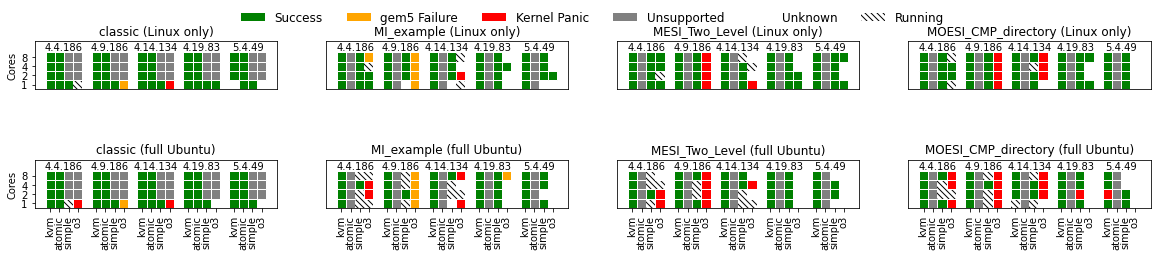

In [4]:
boot_exit_input_space = {
    'kernels': ['4.4.186', '4.9.186', '4.14.134', '4.19.83', '5.4.49'],
    'cpu_types': ['kvm', 'atomic', 'simple', 'o3'],
    'mem_sys': ['classic', 'MI_example', 'MESI_Two_Level', 'MOESI_CMP_directory'],
    'num_cpus': ['1', '2', '4', '8'],
    'boot_types': ['init', 'systemd']
}

boot_exit_runs = get_benchmark_result("boot-exit", results)
boot_exit_status = init_nd_dict(0, list(boot_exit_input_space.keys()), boot_exit_input_space, Status.unknown)

# There are runs that failed due to kvm cpu got stuck randomly, and rerunning the run could result in a different result.
# So, there are runs that are rerun and marked by a different name.
# In this specific case, the original name of this set of runs is `lavandula-pedunculata`, and the set of runs containing the n^{th} reruns has the name of `lavandula-pedunculata;patch-n`
boot_exit_status_version = init_nd_dict(0, list(boot_exit_input_space.keys()), boot_exit_input_space, -1)

# determine unsupported combinations
# for classic memory, simple and o3 with more than 1 core is not supported
# for non classic memory, atomic is not supported
for kernel, cpu_type, mem_sys, num_cpus, boot_type in cross_product(boot_exit_input_space['kernels'],
                                                                    boot_exit_input_space['cpu_types'],
                                                                    boot_exit_input_space['mem_sys'],
                                                                    boot_exit_input_space['num_cpus'],
                                                                    boot_exit_input_space['boot_types']):
    if mem_sys == "classic":
        if cpu_type in ["simple", "o3"]:
            if num_cpus != '1':
                boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] = Status.unsupported
    if mem_sys != "classic":
        if cpu_type == "atomic":
            boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] = Status.unsupported
            

for params, run in boot_exit_runs:
    #print(run.status, run.kill_reason, run.return_code)
    kernel = params['kernel']
    cpu_type = params['cpu']
    mem_sys = params['mem_sys']
    num_cpus = params['num_cpu']
    boot_type = params['boot_type']
    
    # this is specific to the way we name the set of runs as described above
    run_name = run.name.split(";")
    run_version = 0
    if run_name[-1].startswith("patch"):
        run_version = int(run_name[-1].split("-")[-1])
    
    if boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] == Status.unsupported:
        continue
    if run_version > boot_exit_status_version[kernel][cpu_type][mem_sys][num_cpus][boot_type]:
        boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type] = Status.classify(run.status, run.kill_reason)
        boot_exit_status_version[kernel][cpu_type][mem_sys][num_cpus][boot_type] = run_version

patch_boot_exit_result("results.csv", boot_exit_status, all_runs_finished=True)


plt.rcParams["figure.figsize"] = (20,4)
fig, axes = plt.subplots(2, 4, subplot_kw=dict(aspect='equal'))

n = 0
for mem_sys in boot_exit_input_space["mem_sys"]:
    for boot_type in boot_exit_input_space["boot_types"]:
        data = []
        for num_cpus in boot_exit_input_space["num_cpus"]:
            row = []
            col_labels = []
            for i, kernel in enumerate(boot_exit_input_space["kernels"]):
                for cpu_type in boot_exit_input_space["cpu_types"]:
                    row.append(boot_exit_status[kernel][cpu_type][mem_sys][num_cpus][boot_type])
                    col_labels.append(cpu_type)
                if i != len(boot_exit_input_space["kernels"])-1:
                    row.append(Status.separator)
            data.append(row)
        data.append([Status.separator] * len(data[0]))

        qcolor(axes[n%2, n//2], data, Status.get_color_map(), Status.get_hatch_map())
        
        title1 = mem_sys
        title2 = "Linux only" if boot_type == "init" else "full Ubuntu"
        axes[n%2, n//2].set_title("{} ({})".format(title1, title2))
        axes[n%2, n//2].set_xticks([])
        axes[n%2, n//2].set_yticks([])
        for i in range(len(boot_exit_input_space["kernels"])):
            axes[n%2, n//2].text(1.5+i*5.0, 4.2, boot_exit_input_space["kernels"][i], horizontalalignment='center')
        if n%2 == 1:
            axes[n%2, n//2].set_xticks([i for i in range(len(data[0])) if i % 5 != 4])
            axes[n%2, n//2].set_xticklabels(col_labels, rotation=90)
        if n//2 == 0:
            axes[n%2, n//2].set_ylabel("Cores")
            axes[n%2, n//2].set_yticks([i+0.5 for i in range(len(boot_exit_input_space['num_cpus']))])
            axes[n%2, n//2].set_yticklabels(boot_exit_input_space['num_cpus'])
        n+=1
        
# legends
for label, color, hatch in zip(Status.get_legend_labels(), Status.get_color_map(), Status.get_hatch_map()):
    if hatch == '':
        plt.bar(0, 0, label=label, color=color)
    else:
        plt.bar(0, 0, label=label, color=color, hatch = hatch)
plt.legend(bbox_to_anchor=(-1.3,4.3), loc="upper center", ncol=Status.n_cats, prop={'size': 12}, frameon=0)
plt.show()

## General patterns
-  kvm: either stuck randomly or timed out
-  atomic: worked well
-  simple: worked well except for 4.19.83/MOESI_CMP_directory/systemd/2
-  o3: didn't work for 4.9.186 and 4.14.134, failed to boot Ubuntu for 4.4.186, timed out for 5.4.49 while booting Ubuntu

### classic (Linux only)
-  4.9.186/o3/1: `gem5: segfault`
-  4.14.134/o3/1: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`

### classic (Ubuntu)
-  4.4.186/kvm/8: timed out, no apparent cause
-  4.4.186/o3/1: `Ubuntu: kernel BUG at mm/filemap.c:1309!`
-  4.9.186/kvm/4: timed out, no apparent cause
-  4.9.186/o3/1: `gem5: segfault`
-  4.14.134/o3/1: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`
-  5.4.49/o3/1: timed out, no apparent cause [1]

### MI_example (Linux only)
-  4.4.186/o3/8: `gem5: panic: Possible Deadlock detected.`
-  4.9.486/o3/{1,2,4,8}: `gem5: segfault`
-  4.14.134/o3/{1,2,8}: kernel panic due to `linux: BUG: unable to handle kernel paging request at 669066669d57ffc0`
-  4.14.134/o3/4: finished booting, did not run /root/exit.sh
-  4.19.83/o3/{1,8}: `gem5: segfault`

### MI_example (Ubuntu)
-  4.4.186/o3/{1,2,4}: `Ubuntu: kernel BUG at mm/filemap.c:1309!`
-  4.4.186/o3/8: `gem5: panic: Possible Deadlock detected.`
-  4.9.186/kvm/2: timed out, no apparent cause
-  4.9.186/o3/{1,2,4,8}: `gem5: segfault`
-  4.14.134/kvm/8: timed out, no apparent cause
-  4.14.134/o3/{1,2,4,8}: kernel panic due to `linux: BUG: unable to handle kernel paging request at 669066669d57ffc0`
-  4.19.83/kvm/8: timed out, no apparent cause
-  4.19.83/o3/8: `gem5: segfault`

### MESI_Two_Level (Linux only)
-  4.9.186/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel NULL pointer dereference at 000000000000026c`
-  4.14.134/o3/{1,4}: finished booting, did not run /root/exit.sh
-  4.14.134/o3/{2,8}: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`

### MESI_Two_Level (Ubuntu)
-  4.4.186/o3/{1,2,4,8}: `Ubuntu: kernel BUG at mm/filemap.c:1309!`
-  4.9.186/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel NULL pointer dereference at 000000000000026c`
-  4.14.134/o3/{1,2,4}: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`
-  4.14.134/o3/8: finished booting, did not run /root/exit.sh
-  5.4.49/o3/{1,2,4,8}: timed out, no apparent cause [1]

### MOESI_CMP_directory (Linux only)
-  4.9.186/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel NULL pointer dereference at 000000000000026c`
-  4.14.134/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`

### MOESI_CMP_directory (Ubuntu)
-  4.4.186/o3/{1,2,4,8}: `Ubuntu: kernel BUG at mm/filemap.c:1309!`
-  4.9.186/kvm/8: timed out, no apparent cause
-  4.9.186/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel NULL pointer dereference at 000000000000026c`
-  4.14.134/kvm/4: timed out, no apparent cause
-  4.14.134/o3/{1,2,4,8}: `linux: BUG: unable to handle kernel paging request at ffffffffffffffc0`
-  4.19.83/simple/2: `linux: divide error: 0000 [#1] SMP PTI`
-  5.4.49/o3/{1,2,4,8}: timed out, no apparent cause [1]


[1] : stopped/stuck at 
```
[ESC[0;32m  OK  ESC[0m] Started Network Service.
[ESC[0;32m  OK  ESC[0m] Found device /dev/ttyS0.
```
